<a href="https://colab.research.google.com/github/MANASWI-MENDHEKAR/gans_diffusion/blob/main/DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loss: 0.0189: 100%|██████████| 15000/15000 [15:19<00:00, 16.31it/s]


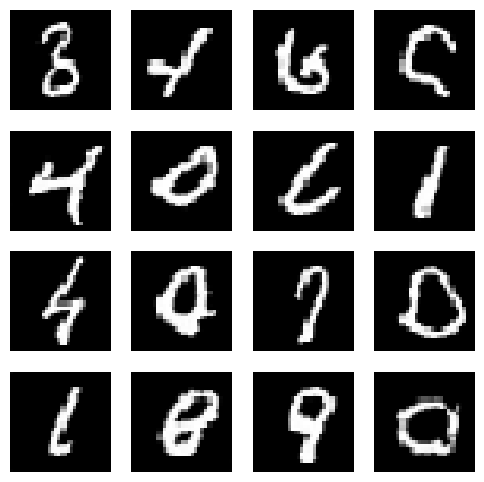

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.datasets.mnist import load_data
import os

# --- 1. U-Net Architecture (Neural Network) ---
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time integration
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        return h

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        time_emb_dim = 32
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv2d(1, 64, 3, padding=1)

        # Downsample steps
        self.down1 = Block(64, 64, time_emb_dim)
        self.down2 = Block(64, 128, time_emb_dim)

        # Bottleneck
        self.bottleneck = Block(128, 128, time_emb_dim)

        # Upsample steps (Input ch doubled because of concat)
        self.up1 = Block(128 + 128, 64, time_emb_dim)
        self.up2 = Block(64 + 64, 64, time_emb_dim)

        self.output = nn.Conv2d(64, 1, 1)

    def forward(self, x, t):
        t = self.time_mlp(t)

        # Encoder
        x0 = self.conv0(x)         # [B, 64, 32, 32]
        x1 = self.down1(x0, t)     # [B, 64, 32, 32]
        p1 = F.max_pool2d(x1, 2)   # [B, 64, 16, 16]

        x2 = self.down2(p1, t)     # [B, 128, 16, 16]
        p2 = F.max_pool2d(x2, 2)   # [B, 128, 8, 8]

        # Bottleneck
        x3 = self.bottleneck(p2, t) # [B, 128, 8, 8]

        # Decoder
        u1 = F.interpolate(x3, scale_factor=2, mode='nearest') # [B, 128, 16, 16]
        u1 = torch.cat((u1, x2), dim=1)                       # [B, 256, 16, 16]
        x4 = self.up1(u1, t)                                  # [B, 64, 16, 16]

        u2 = F.interpolate(x4, scale_factor=2, mode='nearest') # [B, 64, 32, 32]
        u2 = torch.cat((u2, x1), dim=1)                       # [B, 128, 32, 32]
        x5 = self.up2(u2, t)                                  # [B, 64, 32, 32]

        return self.output(x5)

# --- 2. Diffusion Engine ---
class DiffusionModel:
    def __init__(self, T: int, model: nn.Module, device: str):
        self.T = T
        self.model = model.to(device)
        self.device = device
        self.beta = torch.linspace(1e-4, 0.02, T).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.gather(-1, t)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

    def training_step(self, x0, optimizer):
        t = torch.randint(0, self.T, (x0.shape[0],), device=self.device).long()
        eps = torch.randn_like(x0)

        sqrt_alpha_bar_t = self._extract(torch.sqrt(self.alpha_bar), t, x0.shape)
        sqrt_one_minus_alpha_bar_t = self._extract(torch.sqrt(1 - self.alpha_bar), t, x0.shape)

        x_t = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * eps
        eps_predicted = self.model(x_t, t)

        loss = F.mse_loss(eps, eps_predicted)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()

    @torch.no_grad()
    def sampling(self, n=16):
        self.model.eval()
        x = torch.randn((n, 1, 32, 32), device=self.device)
        for t_step in reversed(range(self.T)):
            t = torch.full((n,), t_step, device=self.device, dtype=torch.long)
            eps_theta = self.model(x, t)

            alpha_t = self._extract(self.alpha, t, x.shape)
            alpha_bar_t = self._extract(self.alpha_bar, t, x.shape)
            beta_t = self._extract(self.beta, t, x.shape)

            mean = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * eps_theta)
            z = torch.randn_like(x) if t_step > 0 else 0
            x = mean + torch.sqrt(beta_t) * z
        return (x.clamp(-1, 1) + 1) / 2

# --- 3. Main Execution ---
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    os.makedirs('Imgs', exist_ok=True)

    (trainX, _), (_, _) = load_data()
    trainX = (np.float32(trainX) / 127.5) - 1.0

    model = UNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    diffusion = DiffusionModel(1000, model, device)

    epochs = 15000
    batch_size = 128
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        idx = torch.randint(0, trainX.shape[0], (batch_size,))
        batch = torch.from_numpy(trainX[idx]).unsqueeze(1).to(device)
        batch = F.interpolate(batch, 32)

        loss = diffusion.training_step(batch, optimizer)
        if epoch % 100 == 0:
            pbar.set_description(f"Loss: {loss:.4f}")

    # Generate samples
    samples = diffusion.sampling(n=16)
    plt.figure(figsize=(6, 6))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(samples[i].squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.savefig('Imgs/final_digits.png')
    plt.show()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training on cuda...


100%|██████████| 10000/10000 [11:49<00:00, 14.10it/s]


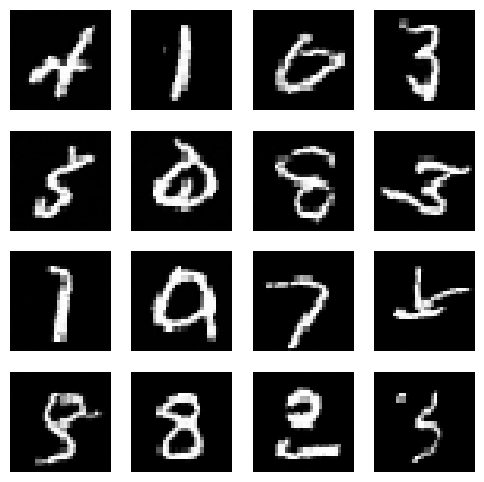

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.datasets.mnist import load_data
import os

# --- 1. Refined U-Net Architecture ---
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        # Using GroupNorm for better stability
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act = nn.SiLU() # SiLU is smoother than ReLU

    def forward(self, x, t):
        h = self.norm1(self.act(self.conv1(x)))
        time_emb = self.act(self.time_mlp(t))[:, :, None, None]
        h = h + time_emb
        h = self.norm2(self.act(self.conv2(h)))
        return h

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        time_emb_dim = 128 # Higher dim for better time tracking
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU()
        )
        self.conv0 = nn.Conv2d(1, 64, 3, padding=1)
        self.down1 = Block(64, 64, time_emb_dim)
        self.down2 = Block(64, 128, time_emb_dim)
        self.bottleneck = Block(128, 128, time_emb_dim)
        self.up1 = Block(128 + 128, 64, time_emb_dim)
        self.up2 = Block(64 + 64, 64, time_emb_dim)
        self.output = nn.Conv2d(64, 1, 1)

    def forward(self, x, t):
        t = self.time_mlp(t)
        x0 = self.conv0(x)
        x1 = self.down1(x0, t)
        p1 = F.avg_pool2d(x1, 2) # Average pooling is smoother for diffusion
        x2 = self.down2(p1, t)
        p2 = F.avg_pool2d(x2, 2)
        x3 = self.bottleneck(p2, t)
        u1 = F.interpolate(x3, scale_factor=2, mode='bilinear', align_corners=False)
        u1 = torch.cat((u1, x2), dim=1)
        x4 = self.up1(u1, t)
        u2 = F.interpolate(x4, scale_factor=2, mode='bilinear', align_corners=False)
        u2 = torch.cat((u2, x1), dim=1)
        x5 = self.up2(u2, t)
        return self.output(x5)

# --- 2. Diffusion Engine ---
class DiffusionModel:
    def __init__(self, T: int, model: nn.Module, device: str):
        self.T, self.model, self.device = T, model.to(device), device
        self.beta = torch.linspace(1e-4, 0.02, T).to(device)
        self.alpha_bar = torch.cumprod(1. - self.beta, dim=0)

    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.gather(-1, t)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

    def training_step(self, x0, optimizer):
        t = torch.randint(0, self.T, (x0.shape[0],), device=self.device).long()
        eps = torch.randn_like(x0)
        a_bar = self._extract(self.alpha_bar, t, x0.shape)
        x_t = torch.sqrt(a_bar) * x0 + torch.sqrt(1 - a_bar) * eps
        loss = F.mse_loss(eps, self.model(x_t, t))
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        return loss.item()

    @torch.no_grad()
    def sampling(self, n=16, steps=200): # Increased steps for quality
        self.model.eval()
        x = torch.randn((n, 1, 32, 32), device=self.device)
        for t_step in reversed(range(self.T)):
            t = torch.full((n,), t_step, device=self.device, dtype=torch.long)
            eps_theta = self.model(x, t)
            a_t = (1. - self.beta).gather(-1, t).reshape(n, 1, 1, 1)
            a_bar_t = self.alpha_bar.gather(-1, t).reshape(n, 1, 1, 1)
            mean = (1 / torch.sqrt(a_t)) * (x - ((1 - a_t) / torch.sqrt(1 - a_bar_t)) * eps_theta)
            z = torch.randn_like(x) if t_step > 0 else 0
            x = mean + torch.sqrt(self.beta.gather(-1, t).reshape(n, 1, 1, 1)) * z
        return (x.clamp(-1, 1) + 1) / 2

# --- 3. Main Loop ---
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Fixed directory check
    if not os.path.exists('Imgs'):
        os.makedirs('Imgs')

    (trainX, _), (_, _) = load_data()
    trainX = (np.float32(trainX) / 127.5) - 1.0

    model = UNet()
    # Swapped Adam for AdamW for better weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
    diffusion = DiffusionModel(1000, model, device)

    print(f"Training on {device}...")
    for i in tqdm(range(10000)): # 10k steps for a solid baseline
        idx = torch.randint(0, trainX.shape[0], (128,))
        batch = torch.from_numpy(trainX[idx]).unsqueeze(1).to(device)
        batch = F.interpolate(batch, 32)
        diffusion.training_step(batch, optimizer)

    samples = diffusion.sampling(n=16, steps=250)
    plt.figure(figsize=(6, 6))
    for i in range(16):
        plt.subplot(4, 4, i+1); plt.imshow(samples[i].squeeze().cpu().numpy(), cmap='gray'); plt.axis('off')

    # Final fix for save error
    plt.savefig('Imgs/final_digits.png')
    plt.show()